In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Flatten, Conv2D, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

In [3]:
def clean_data(text):

    sentence = text.lower()

    sentence = sentence.replace('<br />', '')
    
    # Remove numbers, special characters and extra whitespaces
    sentence = re.sub(r"[^1-9A-Za-zñÑáéíóúÁÉÍÓÚüÜ']+", ' ', sentence)

    return sentence

In [4]:
def preprocess_data(text):

    text['review'] = text['review'].apply(clean_data)
    
    text['sentiment'] = text['sentiment'].apply(lambda x : 1 if x == 'positive' else 0)

    return text['review'].values, text['sentiment'].values

In [5]:
data_path = './IMDB_dataset.csv/IMDB_dataset.csv'

reviews = pd.read_csv(data_path)

In [6]:
display(reviews.head())

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
X, y = preprocess_data(reviews)

Something is weird here. 

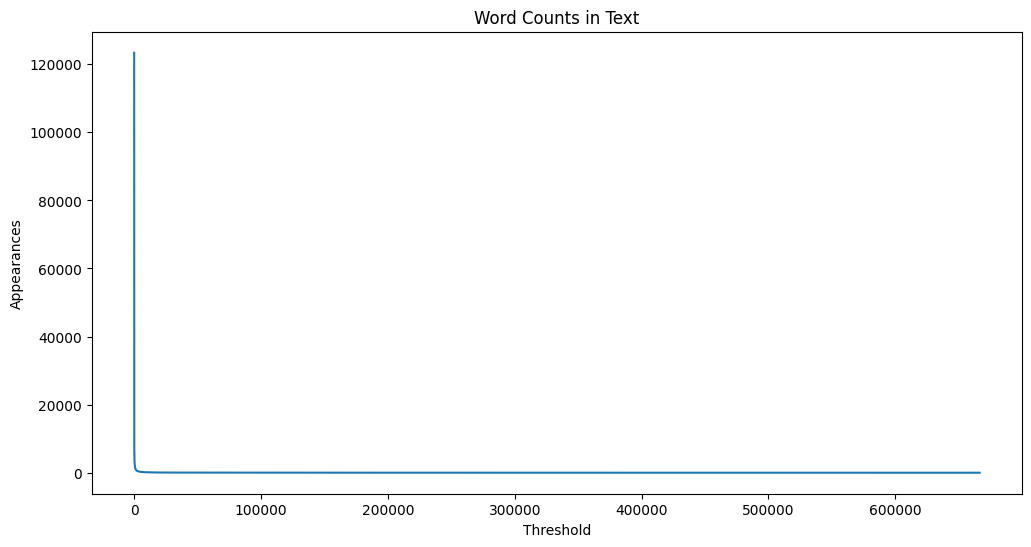

In [21]:
from collections import Counter

clean_text = " ".join(X)

word_counts = Counter(clean_text.split())

# Order the words by their count in descending order
sorted_word_counts = word_counts.most_common()

intervals = np.linspace(0, sorted_word_counts[0][1], 100000)

_ , counts_list = zip(*sorted_word_counts)


less_than_interval_words = [np.array(np.where(counts_list > interval, 1, 0)).sum() for interval in intervals]

# Create a bar plot of word counts
plt.figure(figsize=(12, 6))
plt.plot(intervals, less_than_interval_words)
plt.xlabel("Threshold")
plt.ylabel("Appearances")
plt.title("Word Counts in Text")
plt.show()



In [7]:
display(X[:5], y[:5])

array(["one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare forget

array([1, 1, 1, 0, 1], dtype=int64)

In [8]:
num_words = 1000
max_sequence_length = 100

tokenizer = Tokenizer(num_words = num_words, oov_token = '<OOV>')

tokenizer.fit_on_texts(X)

X_vecs = tokenizer.texts_to_sequences(X)


#Padding might not be necesary in the case that we use an incidence matrix. Also note that this holds no order.
padded_X_vecs = tf.keras.preprocessing.sequence.pad_sequences(X_vecs, maxlen = max_sequence_length, padding="post")

#padded_X_vecs = padded_X_vecs[:10000]

#y = y[:10000]

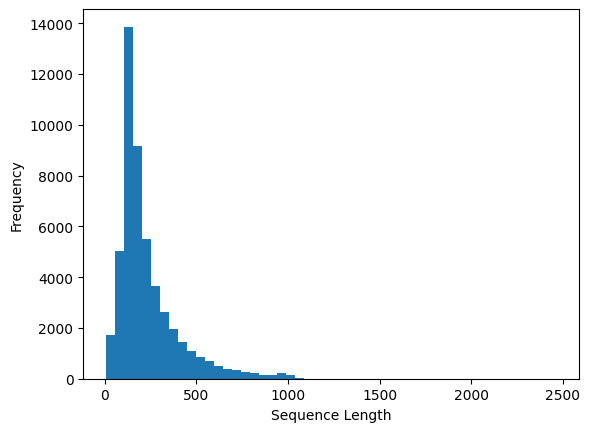

75th percentile: 280.0
90th percentile: 451.0
95th percentile: 589.0
99th percentile: 903.010000000002


In [15]:

sequence_lengths = [len(seq) for seq in X_vecs]

# Plot the histogram
plt.hist(sequence_lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

# Calculate percentiles
print("75th percentile:", np.percentile(sequence_lengths, 75))
print("90th percentile:", np.percentile(sequence_lengths, 90))
print("95th percentile:", np.percentile(sequence_lengths, 95))
print("99th percentile:", np.percentile(sequence_lengths, 99))


In [ ]:
sequence_lengths = [len(seq) for seq in X_vecs]

# Plot the histogram
plt.hist(sequence_lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

# Calculate percentiles
print("75th percentile:", np.percentile(sequence_lengths, 75))
print("90th percentile:", np.percentile(sequence_lengths, 90))
print("95th percentile:", np.percentile(sequence_lengths, 95))
print("99th percentile:", np.percentile(sequence_lengths, 99))

### Improvement suggestions

Here are some recommendations to experiment with your current model:

1. Increase the num_words parameter: Using more words from the vocabulary might help capture additional information that could improve the model's performance.

2. Adjust the max_sequence_length: You can experiment with different sequence lengths to see if it improves the performance. However, keep in mind that very long sequences might increase the training time and memory requirements.

3. Adjust the LSTM layer size: You can experiment with different numbers of LSTM units to see if it improves the performance.

4. Use Bidirectional LSTM: Wrapping your LSTM layer with a Bidirectional layer can help the model learn patterns from both forward and backward directions in the input sequence. To do this, you can use the following line in your build_classifier function:

    x = Bidirectional(LSTM(64))(x)

5. Use dropout: You can add dropout layers or use the dropout and recurrent_dropout parameters within the LSTM layer to regularize the model and help prevent overfitting.

6. Use 1D convolution layer: Instead of a Conv2D layer, you can use a Conv1D layer followed by a GlobalMaxPooling1D or GlobalAveragePooling1D layer to capture local patterns within the input sequences. To do this, you can replace the LSTM layer with:

    x = Conv1D(32, 3, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)

Hyperparameter tuning: Experiment with different hyperparameters, such as learning rate, batch size, and number of training epochs.

Early stopping: Use early stopping with model checkpoints to stop the training when the validation performance starts to degrade, preventing overfitting.



In [9]:

def build_classifier(input_shape, num_words):

    input_layer = Input(shape = input_shape)
    x = Embedding(num_words, 150)(input_layer)
    x = Bidirectional(LSTM(64))(x)
    #x = Flatten()(x)
    x = Dense(64, activation = 'relu')(x)
    
    output_layer = Dense(1, activation = 'sigmoid')(x)

    return Model(input_layer, output_layer)
    

In [10]:
# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Define model checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


In [11]:
model = build_classifier((max_sequence_length,), num_words)

In [12]:
display(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 150)          150000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              110080    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 268,401
Trainable params: 268,401
Non-trainable params: 0
_______________________________________________________

None